In [1]:
import tf
a,b = tf.generate_2random_2darrays(15,15)
lp = tf.laplacian2D(a, 1)
lp2 = tf.laplacian2Dconv(a, 1)

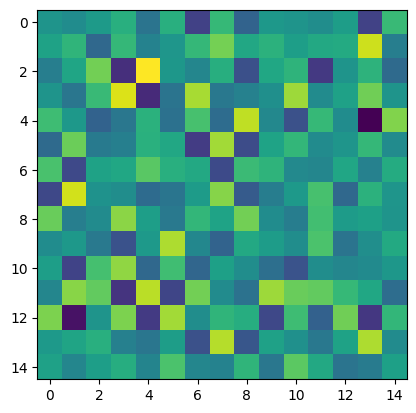

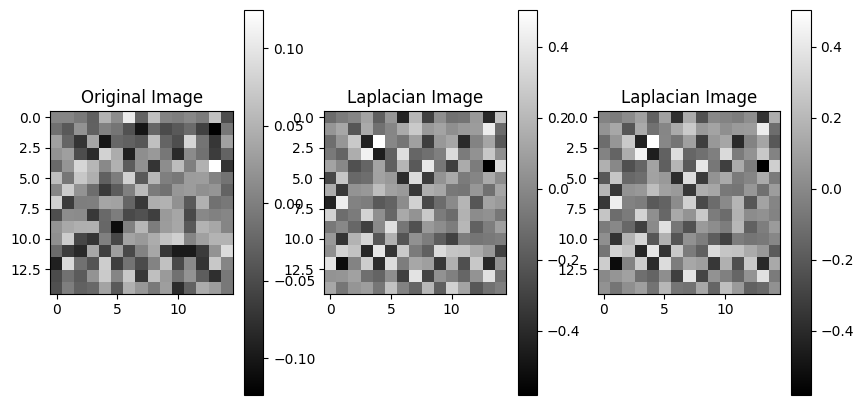

In [2]:
import matplotlib.pyplot as plt
plt.imshow(lp2)

# Plot the original and Laplacian-filtered images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(a, cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Laplacian Image")
plt.imshow(lp, cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Laplacian Image")
plt.imshow(lp2, cmap='gray')
plt.colorbar()

plt.show()
